In [1]:
import numpy as np
import pandas as pd
import scipy, requests, codecs, os, re, nltk, itertools, csv
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
from scipy.stats import spearmanr
import functools as ft
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
import gdown
import json

In [2]:
VEC_LEN = 300
debias_file = open("../Hard_Debias/embeddings/GoogleNews-vectors-negative300-hard-debiased.bin", 'r')
debias_word = {}
for line in debias_file:
    line = line.strip()
    _word = line.split(' ')
    vector = np.array([float(num) for num in _word[1:]])
    if len(vector) != VEC_LEN: 
        raise Exception("Word dimension is wrong")
    debias_word[_word[0]] = vector
debias_file.close()
print(len(debias_word))
hard_debias = debias_word.copy()

322636


In [3]:
VEC_LEN = 300
glove_file = open("../data/glove_wiki_vectors.txt", 'r')
glove_word = {}
for line in glove_file:
    line = line.strip()
    _word = line.split(' ')
    vector = np.array([float(num) for num in _word[1:]])
    if len(vector) != VEC_LEN: 
        raise Exception("Word dimension is wrong")
    glove_word[_word[0]] = vector
glove_file.close()
print(len(glove_word))

322636


In [4]:
gender_specific = []
with open('../data/HSR/male_word_file.txt') as f:
    for l in f:
        gender_specific.append(l.strip())
with open('../data/HSR/female_word_file.txt') as f:
    for l in f:
        gender_specific.append(l.strip())

exclude_words = gender_specific
print(len(exclude_words))

446


In [5]:
import string 
from tqdm import tqdm

def has_punct(w):
    
    if any([c in string.punctuation for c in w]):
        return True
    return False

def has_digit(w):
    
    if any([c in '0123456789' for c in w]):
        return True
    return False

def limit_vocab(word_embedding, exclude = None, vec_len = 300):
    vocab_limited = []
    for w in tqdm(list(word_embedding.keys())[:50000]): 
        if w.lower() != w:
            continue
        if len(w) >= 20:
            continue
        if has_digit(w):
            continue
        if '_' in w:
            p = [has_punct(subw) for subw in w.split('_')]
            if not any(p):
                vocab_limited.append(w)
            continue
        if has_punct(w):
            continue
        vocab_limited.append(w)
    
    if exclude:
        # vocab_limited = list(set(vocab_limited) - set(exclude) - {'melville', 'null', 'nan', 'castellón', 'sgc'})
        vocab_limited = list(set(vocab_limited) - set(exclude))
    
    print("size of vocabulary:", len(vocab_limited))
    
    return vocab_limited

word_limited = limit_vocab(glove_word, exclude_words)

100%|████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:00<00:00, 367610.55it/s]

size of vocabulary: 47698


In [6]:
with open('../definitional_pairs.json', "r") as f:
    defs = json.load(f)
print("definitional", defs)

with open('../equalize_pairs.json', "r") as f:
    equalize_pairs = json.load(f)

with open('../gender_specific_seed.json', "r") as f:
    gender_specific_words = json.load(f)
print("gender specific", len(gender_specific_words), gender_specific_words[:10])

definitional [['woman', 'man'], ['girl', 'boy'], ['she', 'he'], ['mother', 'father'], ['daughter', 'son'], ['gal', 'guy'], ['female', 'male'], ['her', 'his'], ['herself', 'himself'], ['Mary', 'John']]
gender specific 218 ['actress', 'actresses', 'aunt', 'aunts', 'bachelor', 'ballerina', 'barbershop', 'baritone', 'beard', 'beards']


In [7]:
def doPCA(pairs, embedding, num_components = 10):
    matrix = []
    for a, b in pairs:
        a = a.lower()
        b = b.lower()
        try:
            center = (embedding[a] + embedding[b])/2
            matrix.append(embedding[a] - center)
            matrix.append(embedding[b] - center)
        except:
            print("error", a, b)
    matrix = np.array(matrix)
    pca = PCA(n_components = num_components)
    pca.fit(matrix)
    # bar(range(num_components), pca.explained_variance_ratio_)
    return pca

In [8]:
import json 

def extract_professions():
    professions = []
    with codecs.open('../data/HSR/professions.json', 'r', 'utf-8') as f:
        professions_data = json.load(f)
    for item in professions_data:
        professions.append(item[0].strip())
    return professions


professions = extract_professions()

In [9]:
gender_specific = []
with open('../data/HSR/male_word_file.txt') as f:
    for l in f:
        gender_specific.append(l.strip())
with open('../data/HSR/female_word_file.txt') as f:
    for l in f:
        gender_specific.append(l.strip())

exclude_words = gender_specific
print(len(exclude_words))

446


In [10]:
vector_list = []
for w in professions:
    if w in glove_word.keys():
        vector_list.append(glove_word[w])
        
print(len(vector_list))
vector_list = np.array(vector_list)

291


In [11]:
pca_pro = PCA()
pca_pro.fit(vector_list)
comp_pro = pca_pro.components_[:2]
comp_pro.shape

(2, 300)

In [12]:
import operator
pro = {}
for w in word_limited:
    pro[w] = np.linalg.norm(comp_pro.dot(glove_word[w]))
sorted_pro = sorted(pro.items(), key=operator.itemgetter(1))
word_list_pro = [w[0] for w in sorted_pro[-15000:]]

In [13]:
def drop(u, v):
    return u - v * u.dot(v) / v.dot(v)

pca = doPCA(defs, glove_word)
gender_direction = pca.components_[0]

In [14]:
import scipy
def null(A, atol=1e-15, rtol=0):
    A = np.atleast_2d(A)
    u, s, vh = scipy.linalg.svd(A)
    print(s)
    tol = max(atol, rtol * s[0])
    nnz = (s >= tol).sum()
    print(nnz)
    ns = vh[nnz:].conj().T
    return ns
n_space = null(pca.components_[:2])

[1. 1.]
2


In [15]:
n = n_space.shape[1]

np.random.seed(10)

for w in word_list_pro:
    
    rand = np.random.choice(range(n),2)
    null_vec = n_space[:, rand[0]] + n_space[:, rand[1]]
    positive = False
    while positive == False:
        if null_vec.dot(hard_debias[w]) > 0:
            positive = True
            v = hard_debias[w] + 0.3 * comp_pro[0] + 0.3 * (null_vec)
        else:
            rand = np.random.choice(range(n),2)
            null_vec = n_space[:, rand[0]] + n_space[:, rand[1]]
    v = v / np.linalg.norm(v)
    debias_word[w] = v

## Word Projection task

In [16]:
def word_projection(defs, glove_word, comp):

    gender_word = []
    for w in word_list_pro:
        if w in glove_word.keys():
            gender_word.append(w)
    n = len(gender_word)
    total = 0
    for w in gender_word:
        d = comp.dot(glove_word[w])
        total += np.linalg.norm(d)
    pro1 = total / n
    print("Gender projection :", pro1)
    
word_projection(defs, glove_word, gender_direction)
word_projection(defs, hard_debias, gender_direction)
word_projection(defs, debias_word, gender_direction)

Gender projection : 0.414676555316804
Gender projection : 0.008884060580414714
Gender projection : 0.00983099406433445


## Similarity Correlation task

In [17]:
import scipy.stats

def pearson(a,b):
   
    return scipy.stats.pearsonr(a,b)

def compute_corr(tuples, i1, i2):
    
    a = []
    b = []
    for t in tuples:
        a.append(t[i1])
        b.append(t[i2])
    assert(len(a)==len(b))    
    return pearson(a,b)

def word_vec(word_embedding, word_list):
    word_limited_vec = []
    for w in word_list:
        word_limited_vec.append(word_embedding[w])
    word_limited_vec = np.array(word_limited_vec)
    return word_limited_vec

glove_word_vec = word_vec(glove_word, word_limited)
hard_debias_vec = word_vec(hard_debias, word_limited)
debias_word_vec = word_vec(debias_word, word_limited)

In [18]:
def get_tuples_prof(word_embedding, words, word_list, word_limited_vec, gender_bias_dict, b=0.2):

    tuples = []
    
    for w in words:
        if w not in gender_bias_dict:
            continue
            
        # top = topK(w, space, k=105)[:100]
        vec = word_embedding[w]
        sim = word_limited_vec.dot(vec)
        sort_sim = (sim.argsort())[::-1]
        best = sort_sim[:(105+1)]
        
        # if w in words:
        #     print(w)
        # idx = word_list.index(w)
        top = []
        for i in best:
            if word_list[i] != w:
                top.append(word_list[i])
            # else:
                # print("___________________")
                # print(w)
                # raise Exception("Same Word Error")
            
        m = 0
        f = 0  
        for t in top[:100]:          
            if gender_bias_dict[t] > b:
                m+=1
            if gender_bias_dict[t] < -b:
                f+=1
                
        tuples.append((w, gender_bias_dict[w], 0, m, f))
        
        
    return tuples

In [19]:
def compute_bias_by_projection(word_embedding, word_list, direction):
    d = {}
    # for w,m,f in zip(vocab[space_to_tag], males, females):
    #     d[w] = m-f
    for w in word_list:
        
        try:
            d[w] = direction.dot(word_embedding[w])
        except Exception:
            print(w)
            continue
    return d

word_project = compute_bias_by_projection(glove_word, word_limited, gender_direction)
hard_project = compute_bias_by_projection(hard_debias, word_limited, gender_direction)
debias_project = compute_bias_by_projection(debias_word, word_limited, gender_direction)

In [20]:
prof_glove = get_tuples_prof(glove_word, professions, word_limited, glove_word_vec, word_project)
print("Original GloVe: ", compute_corr(prof_glove, 1, 3))
prof_glove = get_tuples_prof(hard_debias, professions, word_limited, hard_debias_vec, word_project)
print("Hard Debias: ", compute_corr(prof_glove, 1, 3))
prof_glove = get_tuples_prof(debias_word, professions, word_limited, debias_word_vec, word_project)
print("DeSim GloVe: ", compute_corr(prof_glove, 1, 3))

Original GloVe:  (0.7820550863231456, 1.8216573265744813e-53)
Hard Debias:  (0.6503461502872573, 8.288788518127686e-32)
DeSim GloVe:  (0.6145846016671008, 1.1377152285927455e-27)


In [21]:
d = {}
for w in word_list_pro:
    d[w] = glove_word[w].dot(gender_direction)
size = 500
sorted_g = sorted(d.items(), key=operator.itemgetter(1))
female_pro = [item[0] for item in sorted_g[:size]]
male_pro = [item[0] for item in sorted_g[-size:]]

In [22]:
# Auxiliary finctions
import matplotlib.pyplot as plt
import matplotlib as mpl
# mpl.use('TkAgg')
from cycler import cycler
import operator
import random


from sklearn.cluster import KMeans
#from sklearn.datasets import make_blobs

from sklearn.manifold import TSNE

def visualize(vectors, words, labels, ax, title, random_state, num_clusters = 2):
    
    # perform TSNE
    
    X_embedded = TSNE(n_components=2, random_state=random_state).fit_transform(vectors)
    if num_clusters == 2:
        for x,l in zip(X_embedded, labels):
            if l:
                ax.scatter(x[0], x[1], marker = '.', c = 'c')
            else:
                ax.scatter(x[0], x[1], marker = 'x', c = 'darkviolet')
    else:
        ax.scatter(X_embedded[:,0], X_embedded[:,1], c = labels)                
    
    ax.set_xlabel("TSNE-X")
    ax.set_ylabel("TSNE-Y")
    ax.set_xbound(lower=-45, upper=45)
    ax.set_ybound(lower=-45, upper=45)
    ax.text(.01, .9, title ,transform=ax.transAxes, fontsize=18)

    
def extract_vectors(words, before, after):
    
    size = len(words)/2
    
    X_bef = [before[x] / np.linalg.norm(before[x]) for x in words]
    X_aft = [after[x] / np.linalg.norm(after[x]) for x in words]

    return X_bef, X_aft

    

def cluster_and_visualize(words, X_bef, X_aft, random_state, y_true, name, num=2):
    
    final = ''
    fig, axs = plt.subplots(1, 2, figsize=(15, 3))
    
    y_pred_bef = KMeans(n_clusters=num, random_state=random_state).fit_predict(X_bef)
    visualize(X_bef, words, y_pred_bef, axs[0], 'Original', random_state)
    # correct = [1 if item1 == item2 else 0 for (item1,item2) in zip(y_true, y_pred_bef) ]
    # final += "original glove dim = 300: {} {} {} ".format(sum(correct), len(correct), sum(correct)/float(len(correct)))
    
    y_pred_aft = KMeans(n_clusters=num, random_state=random_state).fit_predict(X_aft)
    for i in range(0, len(y_pred_aft)):
        if y_pred_aft[i] == 0:
            y_pred_aft[i] = 1
        else:
            y_pred_aft[i] = 0
        
    visualize(X_aft, words, y_pred_aft, axs[1], name, random_state)
#     correct = [1 if item1 == item2 else 0 for (item1,item2) in zip(y_true, y_pred_aft) ]
#     accuracy = sum(correct)/float(len(correct))
#     # print(accuracy)
#     if accuracy < 0.5:
#         accuracy = 1 - accuracy
#     final += "compare with {} ".format(accuracy)
    fig.show()
    fig.savefig('HSR_clustering', bbox_inches='tight')
    


# Cluster most biased words before and after debiasing
def test(before, after, name):
    
    X_bef, X_aft = extract_vectors(male_pro + female_pro, before, after)
    y_true = [0]*size + [1]*size
    return cluster_and_visualize(male_pro + female_pro, X_bef, X_aft, random_state, y_true, name)
    
random.seed(1)
random_state = 1

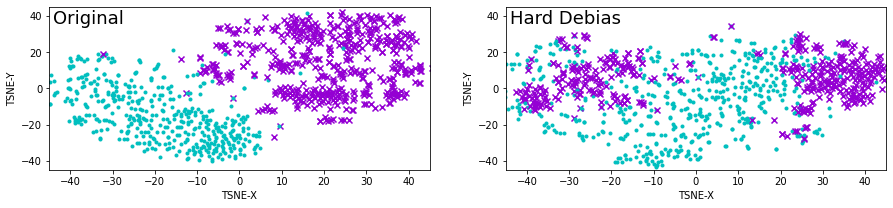

In [23]:
test(glove_word, hard_debias, "Hard Debias")

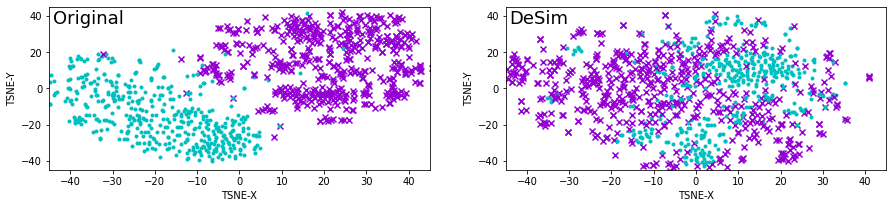

In [24]:
test(glove_word, debias_word, "DeSim")

## Association classification task

In [25]:
male = []
female = []
with open('../data/HSR/male_word_file.txt') as f:
    for l in f:
        male.append(l.strip())
with open('../data/HSR/female_word_file.txt') as f:
    for l in f:
        female.append(l.strip())

exclude_words = male + female
print(len(exclude_words))

446


In [26]:
attribute_sets=[["footballer", 'engineer', 'physician', 'doctor', 'laborer', 'proprietor', 'operator', 'mechanic', 'surveyor', 'physicist', 'machinist', 'architect', 'photographer', 'optometrist', 'millwright', 'sales', 'manager'],
                ["hairdresser","receptionist", 'salesperson', 'setter', 'welder', "cleaner" ,'teacher', 'dancer', 'nutritionist', 'dietitian', 'author', 'nurse', 'attendant', 'waitstaff', 'librarian', 'housekeeper', 'model']]

In [27]:
length = min(len(attribute_sets[0]), len(attribute_sets[1]))
attribute_sets = attribute_sets[0][:length] + attribute_sets[1][:length]
target_sets = [male, female]

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from scipy.stats import entropy

def rnsb(word_embeddings):

    attribute_embeddings = [word_embeddings[w] for w in attribute_sets]

    target_embeddings = [[], []]
    for w in male:
        if w in word_embeddings.keys():
            target_embeddings[0].append(word_embeddings[w])
    for w in female:
        if w in word_embeddings.keys():
            target_embeddings[1].append(word_embeddings[w])

    calculated_divergences = []
    calculated_negative_sentiment_probabilities = []
    scores = []

    # train the logit with the train data.
    X_train = np.array(target_embeddings[0] + target_embeddings[1])
    Y_train = np.array([1]*len(target_embeddings[0]) + [-1]*len(target_embeddings[1]))
    split = train_test_split(
            X_train,
            Y_train,
            shuffle=True,
            test_size=0.1,
            random_state=0,
            stratify=Y_train,
            )
    X_embeddings_train, X_embeddings_test, y_train, y_test = split
    estimator = LogisticRegression(random_state=0)
    estimator.fit(X_embeddings_train, y_train)
    y_pred = estimator.predict(X_embeddings_test)
    score = estimator.score(X_embeddings_test, y_test)
    # print(y_test)
    # print(y_pred, score)
    probabilities = estimator.predict_proba(attribute_embeddings)
    negative_probabilities = probabilities[:, 1].flatten()
    # for n, w in zip(negative_probabilities, target_sets):
    #     print(n,w)

    normalized_negative_probabilities = np.array(negative_probabilities / np.sum(negative_probabilities))
    # print(normalized_negative_probabilities)
    uniform_dist = (np.ones(normalized_negative_probabilities.shape[0])* 1/ normalized_negative_probabilities.shape[0])
    kl_divergence = entropy(normalized_negative_probabilities, uniform_dist)
    print(kl_divergence)

In [29]:
print("Original GloVe:")
rnsb(glove_word)
print("Hard Debias:")
rnsb(hard_debias)
print("DeSim:")
rnsb(debias_word)

Original GloVe:
0.22399039104982316
Hard Debias:
0.012048994282516507
DeSim:
0.01143801118650668


## WEAT task

In [30]:
def similarity(w1, w2):
    
    return w1.dot(w2)

def s_word(w, A, B, word_embedding, all_s_words):
    
    if w in all_s_words:
        return all_s_words[w]
    
    mean_a = []
    mean_b = []
    
    for a in A:
        mean_a.append(similarity(word_embedding[w], word_embedding[a]))
    for b in B:
        mean_b.append(similarity(word_embedding[w], word_embedding[b]))
        
    mean_a = sum(mean_a)/float(len(mean_a))
    mean_b = sum(mean_b)/float(len(mean_b))
    
    all_s_words[w] = mean_a - mean_b

    return all_s_words[w]


def s_group(X, Y, A, B, word_embedding, all_s_words):
    
    total = 0
    for x in X:
        total += s_word(x, A, B, word_embedding, all_s_words)
    for y in Y:
        total -= s_word(y, A, B, word_embedding, all_s_words)
        
    return total

def effect_size(X, Y, A, B, word_embedding, all_s_words):
    total_x = []
    total_y = []
    
    for x in X:
        total_x.append(s_word(x, A, B, word_embedding, all_s_words))
    for y in Y:
        total_y.append(s_word(y, A, B, word_embedding, all_s_words))
        
    
    mean = sum(total_x)/float(len(total_x)) - sum(total_y)/float(len(total_y))
    std_dev = np.std(total_x + total_y)
    
    if std_dev == 0:
        print("Error! ")
    
    return mean / std_dev


def p_value_exhust(X, Y, A, B, word_embedding):
    
#     if len(X) > 10:
#         print('might take too long, use sampled version: p_value')
#         return
    

    _X = []
    _Y = []
    _A = []
    _B = []
    for x in X:
        if x in word_embedding.keys():
            _X.append(x)
            
    for y in Y:
        if y in word_embedding.keys():
            _Y.append(y)
            
    for a in A:
        if a in word_embedding.keys():
            _A.append(a)
            
    for b in B:
        if b in word_embedding.keys():
            _B.append(b)
            
    length = min(10, len(_X), len(_Y))
    X = _X[:length]
    Y = _Y[:length]
    
    A = _A
    B = _B
    
    all_s_words = {}
    s_orig = s_group(X, Y, A, B, word_embedding, all_s_words) 
    
    union = set(X+Y)
    subset_size = int(len(union)/2)
    
    larger = 0
    total = 0

    for subset in set(itertools.combinations(union, subset_size)):
        total += 1
        Xi = list(set(subset))
        Yi = list(union - set(subset))
        if s_group(Xi, Yi, A, B, word_embedding, all_s_words) > s_orig:
            larger += 1
    print('num of samples {} '.format(total))
    
    d = effect_size(X, Y, A, B, word_embedding, all_s_words)

    
    return larger/float(total), d

In [31]:
X = ['john', 'paul', 'mike', 'kevin', 'steve', 'greg', 'jeff', 'bill']
Y = ['amy', 'joan', 'lisa', 'sarah', 'diana', 'kate', 'ann', 'donna']
A = ['executive', 'management', 'professional', 'corporation', 'salary', 'office', 'business', 'career']
B = ['home', 'parents', 'children', 'family', 'cousins', 'marriage', 'wedding', 'relatives']

print(p_value_exhust(X, Y, A, B, glove_word))
print(p_value_exhust(X, Y, A, B, debias_word))

num of samples 12870 
(0.0, 1.9084065924005231)
num of samples 12870 
(7.77000777000777e-05, 1.6681019161944972)


In [32]:
A = ['judge', 'physician', 'doctor', 'laborer', 'conservationist', 'proprietor', 'operator', 'mechanic', 'surveyor']
B = ['bankteller', 'cashier', 'librarian', 'accountant' , 'teacher', 'baker', 'nurse', 'secretary', 'clerical']

print(p_value_exhust(X, Y, A, B, glove_word))
print(p_value_exhust(X, Y, A, B, debias_word))

num of samples 12870 
(0.0006216006216006216, 1.475577799823717)
num of samples 12870 
(0.5668220668220668, -0.09640361996133391)


In [33]:
A = ['caress', 'health', 'love', 'heaven', 'pleasure', 'gentle', 'honest', 'lucky', 'rainbow', 'diploma', 'gift', 'honor', 'sunrise', 'bright', 'happy', 'laughter']
B = ['bitter', 'crash', 'filth', 'cry', 'grief', 'stink', 'assault', 'disaster', 'angry', 'tragedy', 'divorce', 'fragile', 'poverty', 'ugly', 'sad', 'rotten']

print(p_value_exhust(X, Y, A, B, glove_word))
print(p_value_exhust(X, Y, A, B, debias_word))

num of samples 12870 
(0.08865578865578866, 0.7066670479948265)
num of samples 12870 
(0.16285936285936287, 0.521484809999423)


In [34]:
X = ['he', 'his', 'male', 'son', 'mr', 'gentle', 'boy', 'father']
Y = ['she', 'her', 'female', 'daughter', 'mrs', 'lady', 'girl', 'mother']
A = ['executive', 'management', 'professional', 'corporation', 'salary', 'office', 'business', 'career']
B = ['home', 'parents', 'children', 'family', 'cousins', 'marriage', 'wedding', 'relatives']

print(p_value_exhust(X, Y, A, B, glove_word))
print(p_value_exhust(X, Y, A, B, debias_word))

num of samples 12870 
(0.0822066822066822, 0.7270437807678093)
num of samples 12870 
(0.4766899766899767, 0.03399363452923407)


In [35]:
A = ['judge', 'physician', 'doctor', 'laborer', 'conservationist', 'proprietor', 'operator', 'mechanic', 'surveyor']
B = ['bankteller', 'cashier', 'librarian', 'accountant' , 'teacher', 'baker', 'nurse', 'secretary', 'clerical']

print(p_value_exhust(X, Y, A, B, glove_word))
print(p_value_exhust(X, Y, A, B, debias_word))

num of samples 12870 
(0.0002331002331002331, 1.6109151334676957)
num of samples 12870 
(0.23108003108003108, 0.39428740139082213)


In [36]:
A = ['caress', 'health', 'love', 'heaven', 'pleasure', 'gentle', 'honest', 'lucky', 'rainbow', 'diploma', 'gift', 'honor', 'sunrise', 'bright', 'happy', 'laughter']
B = ['bitter', 'crash', 'filth', 'cry', 'grief', 'stink', 'assault', 'disaster', 'angry', 'tragedy', 'divorce', 'fragile', 'poverty', 'ugly', 'sad', 'rotten']

print(p_value_exhust(X, Y, A, B, glove_word))
print(p_value_exhust(X, Y, A, B, debias_word))

num of samples 12870 
(0.17956487956487957, 0.5009753645477947)
num of samples 12870 
(0.2616938616938617, 0.36509284516643964)
